In [1]:
%reload_ext autoreload
%autoreload 2

import osmnx as ox # OSMnx library for street networks using OpenStreetMap data
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

from copy import deepcopy

In [2]:
# download/model a street network for some city then visualize it
# G = ox.graph_from_place("Manchester, UK", network_type="drive")

# Coordinates of the Dalton Building
point = 53.472075, -2.238855

# Get data from open street maps and plot network
G = ox.graph_from_point(point, dist=2000, network_type="drive", simplify=True)

In [3]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.union_all().convex_hull.area
print(f"Graph area is {int(graph_area_m):,} m^2")

Graph area is 15,823,953 m^2


In [4]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [5]:
# # convert graph to line graph so edges become nodes and vice versa
# edge_centrality = nx.closeness_centrality(nx.line_graph(G))
# nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

# # color edges in original graph with closeness centralities from line graph
# ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
# fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

<img src="dalton_building_heatmap.png" alt="heatmap" width="400"/>

In [6]:
# place = "Manchester Central, Manchester, England, UK"
# tags = {"building": True}
# gdf = ox.features_from_place(place, tags)
# gdf.shape

# fig, ax = ox.plot_footprints(gdf, figsize=(10, 10), alpha=0.7)

<img src="man_central_buildings_plot.png" alt="central_man" width="400"/>

In [7]:
start = ox.distance.nearest_nodes(G, Y=53.472075, X=-2.238855) # Dalton Building
# dest = ox.distance.nearest_nodes(G, Y=53.487124, X=-2.242696) # Victoria Station

dest = ox.distance.nearest_nodes(G, Y=53.47, X=-2.24)
start, dest

(3356365, 5092787125)

In [8]:
# The xs method returns a cross-section from the DataFrame
gdf_edges.xs(start, level="u")

osmid      highway maxspeed  \
v       key                                                              
3356363 0                               28047780    secondary   20 mph   
3356289 0                              184507807  residential   20 mph   
643137  0    [1311842160, 1311842161, 116583594]    secondary   20 mph   

                       name  oneway reversed      length lanes    ref  \
v       key                                                             
3356363 0       Oxford Road   False    False   95.899214     2  B5117   
3356289 0    Chester Street   False     True  115.890026   NaN    NaN   
643137  0       Oxford Road   False    False  181.671413     2  B5117   

                                                      geometry bridge tunnel  \
v       key                                                                    
3356363 0    LINESTRING (-2.23929 53.47256, -2.23981 53.473...    NaN    NaN   
3356289 0    LINESTRING (-2.23929 53.47256, -2.23944 53.472...    NaN    NaN   
643137  0    LINESTRING (-2.23929 53.47256, -2.23927 53.472...    NaN    NaN   

            junction width access  
v       key                        
3356363 0        NaN   NaN    NaN  
3356289 0        NaN   NaN    NaN  
643137  0        NaN   NaN    NaN

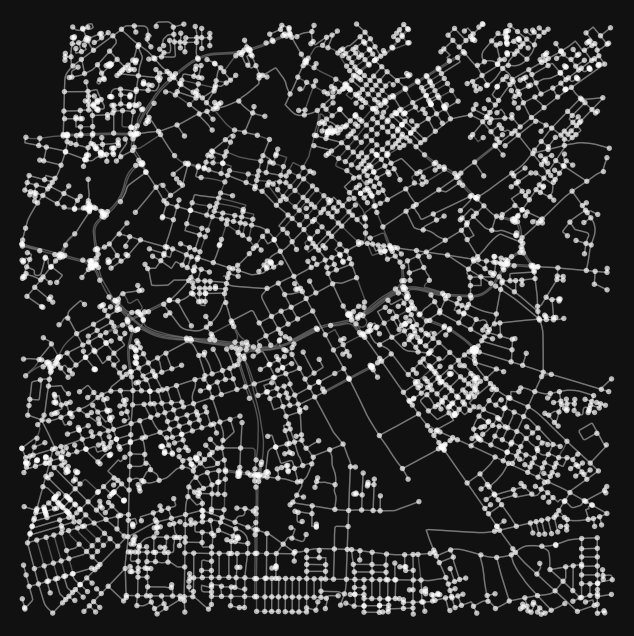

In [9]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 8),facecolor="#111111");
ax.set_facecolor("#111111")
fig, ax, scatter = ox.plot_graph(G, ax=ax, node_alpha=0.7, edge_alpha=0.5);

# Create a list of nodes and get the number of points in the graph.
nodes = list(G.nodes())
num_points = len(list(G))

# Create a dictionary of adjacent node for efficient look-up.
adj_dict = {n: adjacent_node_dict for n, adjacent_node_dict in G.adjacency()}

# Visualising

In [10]:
 # Create a dictionary to map nodes to their index in a list
node_index_map = {nodes[i]: i for i in range(num_points)}

def update_graph_visuals(current_node, closed_set):
    '''
    Function to update the sizes and colours of the nodes in the graph.
    '''

    # Initially set sizes and colours to defaults (size 10, colour white)
    sizes = [10 for i in range(num_points)]
    colours = ["#FFFFFF" for i in range(num_points)] 

    # Loop through all closed (visited) nodes and set them to yellow and size 10
    if len(closed_set) > 0:
        sizes[node_index_map[closed_set[-1]]] = 10
        colours[node_index_map[closed_set[-1]]] = "#FFFF00"

    # Set destination node to size 30 and to purple colour 
    colours[node_index_map[dest]] = "#FF00FF"
    sizes[node_index_map[dest]] = 30
    
    # Set the current node to size 50 and to red colour
    sizes[node_index_map[current_node]] = 50
    colours[node_index_map[current_node]] = "#FF0000"

    # Update the sizes and colours of the nodes in the scatter plot.
    scatter.set_sizes(sizes)
    scatter.set_color(colours)

    return scatter

# Searching

In [11]:
closed = []
open = [start]
done = False


def search():
    global done

    if done: return 

    node = open.pop(0)
    
    done = (node == dest)

    open.extend([key for key in adj_dict[node].keys() if key not in closed])

    closed.append(node)

    return node

# Running

In [12]:
# Animation function
def animate(frame):
    next_node = search()
    update_graph_visuals(next_node, closed)
    return scatter

# Create the animation
ani = FuncAnimation(fig, animate, frames=10, interval=200)

HTML(ani.to_jshtml())
# ani.save("bfs_manchester.mp4")